# Definition of the model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from constants import *
import time
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [52]:
class BeatTracker(nn.Module):
    
    def __init__(self, hidden_size=128, num_layers=2):
        super(BeatTracker, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
                        nb, 
                        hidden_size, 
                        num_layers, 
                        bidirectional=True, 
                        dropout=0.5,
                        batch_first=True)
        self.hid_to_beat = nn.Linear(2 * hidden_size, 2)
        self.hidden = None
        
        self.loss_function = nn.NLLLoss()
        
        self.lr = 0.001
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, spec):
        x = self.lstm(spec)[0]
        x = self.hid_to_beat(x)
        x = F.log_softmax(x, dim=-1)
        return x
    
    def set_lr(self, lr):
        self.lr = lr
        for p in self.optimizer.param_groups:
            p['lr'] = lr
            
    def learn(self, spec, onsets, isbeat):
        self.optimizer.zero_grad()
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        loss.backward()
        self.optimizer.step()
        
        predic = torch.argmax(output, dim=1)
        accuracy = torch.sum(predic == target).item() / predic.shape.numel()
        
        return loss.item(), accuracy
    
    def fit(self, dataset, batch_size=1, epochs=1):
        loss_hist = np.zeros((epochs, -(-len(dataset) // batch_size)))
        accu_hist = np.zeros((epochs, -(-len(dataset) // batch_size)))
        for e in range(epochs):
            start = time.time()
            
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, (spec, onsets, isbeat) in enumerate(dataloader):
                loss, accuracy = self.learn(spec, onsets, isbeat)
                loss_hist[e, i] = loss
                accu_hist[e, i] = accuracy
            
            end = time.time()
            t = end - start
            eta = str(datetime.timedelta(seconds=int(t * (epochs - e - 1))))
            print(f'| Epoch: {e + 1:{len(str(epochs))}} | ', end='')
            print(f'Loss: {np.mean(loss_hist[e]):7.4f} | ', end='')
            print(f'Accuracy: {np.mean(accu_hist[e]):5.4f} | ', end='')
            print(f'{t / len(dataloader):.2f} s/b | Eta: {eta} |')
        return loss_hist, accu_hist
    
    def predict(self, specs, onsets):
        """So far only works if batch_size = 1"""
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            pred_t = torch.argmax(output, dim=1)
            onsets_frames = np.argwhere(onsets.squeeze(0) == 1).squeeze(0)
            beats_frames = onsets_frames[pred_t == 1]
            pred = torch.zeros_like(onsets)
            pred[:, beats_frames] = 1
        return pred
    
    def evaluate(self, specs, onsets, isbeat):
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            target = isbeat[onsets == 1]
            predic = torch.argmax(output, dim=1)
            
            tn = torch.sum((predic == 0) & (target == 0)).item()
            fp = torch.sum((predic == 1) & (target == 0)).item()
            fn = torch.sum((predic == 0) & (target == 1)).item()
            tp = torch.sum((predic == 1) & (target == 1)).item()
        return tn, fp, fn, tp
    
    def evaluate_from_dataset(self, dataset):
        dataloader = DataLoader(dataset, batch_size=1)
        ttn = 0
        tfp = 0
        tfn = 0
        ttp = 0
        for specs, onsets, isbeat in dataloader:
            tn, fp, fn, tp = self.evaluate(specs, onsets, isbeat)
            ttn += tn
            tfp += fp
            tfn += fn
            ttp += tp
        return ttn, tfp, tfn, ttp
    
    def freeze(self):
        for p in self.parameters():
            p.requires_grad = False
            
    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad = True

class ToTensor(object):
    
    def __call__(self, sample):
        spec_np, onsets_np, isbeat_np = sample
        
        # Normalize to [-1, 1]
        spec_np = 2 * (spec_np - spec_np.min()) / (spec_np.max() - spec_np.min()) - 1
        spec = torch.tensor(spec_np.T, dtype=torch.float, device=device)
        
        onsets = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        isbeat = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        
        onsets[onsets_np] = 1
        isbeat[onsets_np[isbeat_np == 1]] = 1
        
        return spec, onsets, isbeat
    
def beat_track(isbeat):
    onset_envelope = isbeat.squeeze(0).numpy()
    tempo, bt = librosa.beat.beat_track(
                            sr=sr, 
                            onset_envelope=onset_envelope, 
                            hop_length=hl, 
                            tightness=800)
    return bt

# Visualization of the dataset

In [66]:
from GTZAN import GTZAN
from visualization import *

Take a subset of the GTZAN dataset preprocessed using `preprocess-GTZAN` and split it into a train set and a validation set.

In [67]:
dataset = GTZAN(937, 'country', 20, getbeats=True)

Visualize an example.

In [68]:
spec, onsets, isbeat, beats = dataset[np.random.randint(len(dataset))]

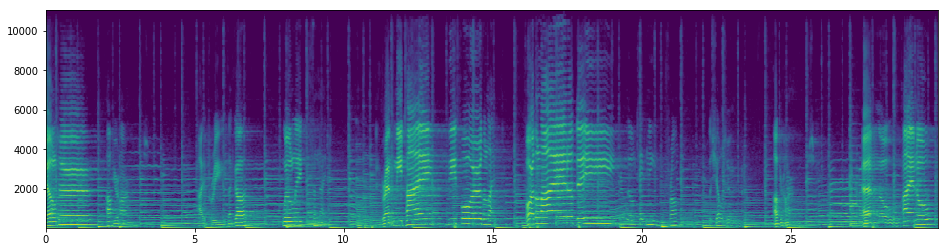

In [69]:
showspec(spec)

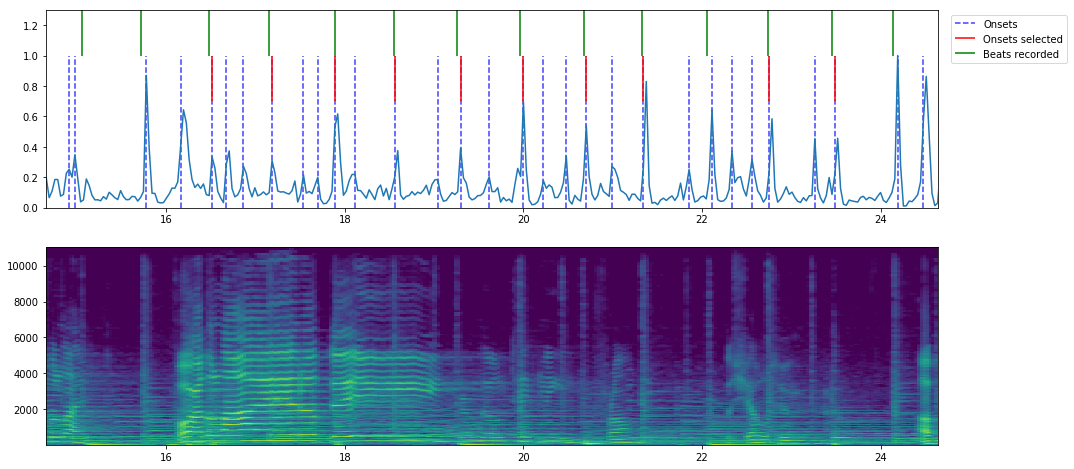

In [70]:
showdata(spec, onsets, isbeat, beats, duration=10)

# Training of the model

In [71]:
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [73]:
model = BeatTracker(hidden_size=128, num_layers=2)
model.to(device)
print_params(model)

 ----------------------------------------------------------
| lstm.weight_ih_l0            | [512, 229]   |    117,248 |
| lstm.weight_hh_l0            | [512, 128]   |     65,536 |
| lstm.bias_ih_l0              | [512]        |        512 |
| lstm.bias_hh_l0              | [512]        |        512 |
| lstm.weight_ih_l0_reverse    | [512, 229]   |    117,248 |
| lstm.weight_hh_l0_reverse    | [512, 128]   |     65,536 |
| lstm.bias_ih_l0_reverse      | [512]        |        512 |
| lstm.bias_hh_l0_reverse      | [512]        |        512 |
| lstm.weight_ih_l1            | [512, 256]   |    131,072 |
| lstm.weight_hh_l1            | [512, 128]   |     65,536 |
| lstm.bias_ih_l1              | [512]        |        512 |
| lstm.bias_hh_l1              | [512]        |        512 |
| lstm.weight_ih_l1_reverse    | [512, 256]   |    131,072 |
| lstm.weight_hh_l1_reverse    | [512, 128]   |     65,536 |
| lstm.bias_ih_l1_reverse      | [512]        |        512 |
| lstm.bias_hh_l1_reverse

In [74]:
dataset = GTZAN(transform=ToTensor())

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
trainset, validset = random_split(dataset, [train_size, valid_size])

print(f'Train size: {train_size}')
print(f'Valid size: {valid_size}')

Train size: 800
Valid size: 200


In [75]:
confusion(*model.evaluate_from_dataset(validset))

 -----------------------
| tp:  1321 | fp:  2536 |
| fn:  7506 | tn: 10921 |
 -----------------------
Precision: 0.3425
   Recall: 0.1497
 Accuracy: 0.5494


In [76]:
confusion(*model.evaluate_from_dataset(trainset))

 -----------------------
| tp:  4766 | fp:  8494 |
| fn: 33220 | tn: 47464 |
 -----------------------
Precision: 0.3594
   Recall: 0.1255
 Accuracy: 0.5560


In [77]:
lost_hist, accu_hist = model.fit(trainset, batch_size=3, epochs=10)

| Epoch:  1 | Loss:  0.4885 | Accuracy: 0.7657 | 0.14 s/b | Eta: 0:05:34 |
| Epoch:  2 | Loss:  0.4954 | Accuracy: 0.7627 | 0.14 s/b | Eta: 0:04:58 |
| Epoch:  3 | Loss:  0.4898 | Accuracy: 0.7662 | 0.14 s/b | Eta: 0:04:16 |
| Epoch:  4 | Loss:  0.4457 | Accuracy: 0.7943 | 0.14 s/b | Eta: 0:03:46 |
| Epoch:  5 | Loss:  0.4263 | Accuracy: 0.8047 | 0.14 s/b | Eta: 0:03:04 |
| Epoch:  6 | Loss:  0.4140 | Accuracy: 0.8105 | 0.14 s/b | Eta: 0:02:28 |
| Epoch:  7 | Loss:  0.4030 | Accuracy: 0.8185 | 0.14 s/b | Eta: 0:01:50 |
| Epoch:  8 | Loss:  0.3967 | Accuracy: 0.8215 | 0.13 s/b | Eta: 0:01:12 |
| Epoch:  9 | Loss:  0.3891 | Accuracy: 0.8250 | 0.14 s/b | Eta: 0:00:37 |
| Epoch: 10 | Loss:  0.3830 | Accuracy: 0.8286 | 0.14 s/b | Eta: 0:00:00 |


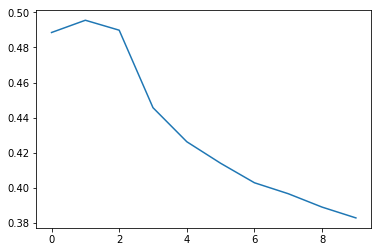

In [78]:
plt.plot(np.mean(lost_hist, axis=1));

In [79]:
confusion(*model.evaluate_from_dataset(validset))

 -----------------------
| tp:  6240 | fp:  2018 |
| fn:  2587 | tn: 11439 |
 -----------------------
Precision: 0.7556
   Recall: 0.7069
 Accuracy: 0.7933


In [80]:
confusion(*model.evaluate_from_dataset(trainset))

 -----------------------
| tp: 29435 | fp:  6872 |
| fn:  8551 | tn: 49086 |
 -----------------------
Precision: 0.8107
   Recall: 0.7749
 Accuracy: 0.8358


In [81]:
torch.save(model.state_dict(), './data/model_02.pt')

# Test